# HW2

In [1]:
# Importing the required libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
import heapq

#### Now we will add the classes required for a fully connected layer, softmax activation layer with cross entropy loss and a class for the Network itself.

In [2]:
# Class for Fully connected layer
class FCLayer:
    input = None
    output = None
    weights = None
    bias = None

    # Forward propagation
    def fwd_prop(self, inp):
        self.input = inp
        self.output = np.dot(inp, self.weights) + self.bias
        return self.output

    # Backward propagation 
    def back_prop(self, error, learning_rate):
        back_prop_input = np.dot(error, self.weights.T)
        back_prop_weights = (np.dot(self.input.T, error))/self.input.shape[0]
        self.weights -= learning_rate * back_prop_weights
        self.bias -= learning_rate * error.sum(axis=0)/self.input.shape[0]

        return back_prop_input

# Class for Softmax layer with cross entropy loss
class SoftmaxLayer:
    input = None
    output = None

    def softmax_activation(self):
        return np.exp(self.input)/np.exp(self.input).sum(axis=1)[:,None]

    def gradient_softmax_activation(self):
        return np.sum(np.eye(self.input.shape[1]) * self.input[:,np.newaxis,:] - np.einsum('ij,ij->i', self.input, self.input)[:,None,None], axis=1)

    def gradient_softmax_with_cross_entropy(self, actual, expected):
        return actual - expected

    # Forward propagation
    def fwd_prop(self, inp):
        self.input = inp
        self.output = self.softmax_activation()
        return self.output

    # Backward propagation 
    def back_prop(self, expected):
        return self.gradient_softmax_with_cross_entropy(self.output, expected)
        

# Class for the Multi Layer Perceptron Network
class Network:
    layers = []
    learning_rate = None
    epochs = None
    batch_size = None
    
    def __init__(self, learning_rate, epochs, batch_size):
        self.layers = []
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
    # Method for adding a fully connected layer
    def add_fc_layer(self, inp_size, op_size):
        fc_layer = FCLayer()
        fc_layer.weights = np.random.uniform(-1.0, 1.0, size=(inp_size, op_size))
        fc_layer.bias = np.random.uniform(-1.0, 1.0, size=(op_size))
        self.layers.append(fc_layer)
    
    # Method for adding a softmax layer
    def add_softmax_layer(self):
        ac_layer = SoftmaxLayer()
        self.layers.append(ac_layer)
    
    # Cross Entropy loss function
    def cross_entropy_loss(self, expected, actual):
        return -np.sum(expected*np.log(actual))
    
    def gradient_cross_entropy_loss(self, actual, expected):
        return -expected/actual
    
    # Multi batch gradient descent training
    def train_mbgd(self, x_train, y_train, x_test, y_test, show_progress=True):
        list_n = np.logspace(start=np.log10(2), stop=np.log10(self.epochs), num=10, dtype =int)
        list_acc = []
        list_n_idx = 0
        for epoch in range(self.epochs): # Epoch
            x_train_mini_batch = []
            y_train_mini_batch = []
            loss = 0
            no_of_batches_done = 0;
            total_no_of_batches = (int) (x_train.shape[0]/self.batch_size)
            for id in range(x_train.shape[0]): # Gradient descent
                x = x_train[id]
                y = y_train[id]
                x_train_mini_batch.append(x)
                y_train_mini_batch.append(y)

                if len(y_train_mini_batch) == self.batch_size: # Mini batch
                    x_train_mini_batch = np.array(x_train_mini_batch, dtype=np.float128)
                    y_train_mini_batch = np.array(y_train_mini_batch, dtype=np.float128)

                    output = x_train_mini_batch
                    for layer in self.layers:
                        output = layer.fwd_prop(output)

                    loss += self.cross_entropy_loss(y_train_mini_batch, output)
#                     print(epoch, output, np.sum(output))

                    back_prop_err = self.layers[-1].back_prop(y_train_mini_batch)
                    for layer in reversed(self.layers[:-1]):
                        back_prop_err = layer.back_prop(back_prop_err, self.learning_rate)

                    x_train_mini_batch = []
                    y_train_mini_batch = []
                    no_of_batches_done += 1;
                    if show_progress:
                        sys.stdout.write('\r')
                        percentage_completion = (int)(no_of_batches_done*100/total_no_of_batches)
                        sys.stdout.write("[%-20s] %d%% " % ('='*(int)(percentage_completion/5), percentage_completion))
                        sys.stdout.flush()
            print('Epoch - ', epoch, '; Loss - ', loss/y_train.shape[0])
            
            if list_n_idx < len(list_n) and list_n[list_n_idx] == epoch+1:
                list_acc.append(self.test(x_test, y_test))
                list_n_idx += 1
        
        plt.title('Number of Epochs vs Accuracy') 
        plt.xlabel('Number of Epochs') 
        plt.ylabel('Accuracy')
        plt.legend()
        plt.plot(list_n, list_acc, label='mini_batch_size = ' + str(self.batch_size))
                
    
    # Testing
    def test(self, x_test, y_test):
        op = np.array(x_test, dtype=np.float128)
        for layer in self.layers:
            op = layer.fwd_prop(op)
                  
        return 1 - np.count_nonzero(op.argmax(axis=1) - y_test.argmax(axis=1))/x_test.shape[0]

#### Load dataset and preprocessing

In [3]:
# Loading the data from external file
data = loadmat('MNIST_digit_data.mat')
images_train, images_test, labels_train, labels_test = \
    data['images_train'], data['images_test'], data['labels_train'], data['labels_test']

# Preprocessing the data to make it suitable for prediction
# Set seed to make the permutation same across all machines
np.random.seed(1)

# randomly permute data points
indexes = np.random.permutation(images_train.shape[0])
images_train = images_train[indexes]
labels_train = labels_train[indexes]
indexes = np.random.permutation(images_test.shape[0])
images_test = images_test[indexes]
labels_test = labels_test[indexes]

# Flatten training images
images_train = images_train.reshape(len(images_train),-1)
images_test = images_test.reshape(len(images_test),-1)

# Changing label arrays to 1-D
labels_train_1d = labels_train.flatten()
labels_test_1d = labels_test.flatten()

# Convert to one-hot encoding
labels_train_one_hot = np.zeros((labels_train_1d.size, 10))
labels_train_one_hot[np.arange(labels_train_1d.size), labels_train_1d] = 1

labels_test_one_hot = np.zeros((labels_test_1d.size, 10))
labels_test_one_hot[np.arange(labels_test_1d.size), labels_test_1d] = 1

#### Exercise 1: Network with one hidden layer, softmax activation and cross entropy loss

In [4]:
# Initialize network
network = Network(0.01, 100, 10)
network.add_fc_layer(784, 10)
network.add_softmax_layer()

[====================] 100% Epoch -  0 ; Loss -  1.3081660715880679724
[====================] 100% Epoch -  1 ; Loss -  0.60111632699130395334
[====================] 100% Epoch -  2 ; Loss -  0.50865752365989831614
[====================] 100% Epoch -  3 ; Loss -  0.46228669438553738033
[====================] 100% Epoch -  4 ; Loss -  0.43272603547879783558
[====================] 100% Epoch -  5 ; Loss -  0.41164811645220908285
[====================] 100% Epoch -  6 ; Loss -  0.3955823709761202548
[====================] 100% Epoch -  7 ; Loss -  0.38277706148755889488
[====================] 100% Epoch -  8 ; Loss -  0.372237939631784517
[====================] 100% Epoch -  9 ; Loss -  0.36335341876753520413
[====================] 100% Epoch -  10 ; Loss -  0.35572372545672433533
[====================] 100% Epoch -  11 ; Loss -  0.34907459084115658352
[====================] 100% Epoch -  12 ; Loss -  0.34321031912681342603
[====================] 100% Epoch -  13 ; Loss -  0.3379867097189

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


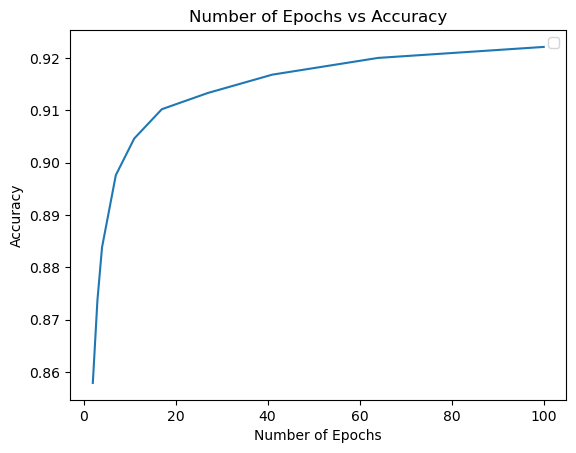

Final Accuracy -  0.9221


In [5]:
# Train network and get accuracy
network.train_mbgd(images_train, labels_train_one_hot, images_test, labels_test_one_hot)
plt.show()
print('Final Accuracy - ', network.test(images_test, labels_test_one_hot))

#### Exercise 2: Images misclassified with highest score.

Predicted Label -  0
Wrong Predictions:


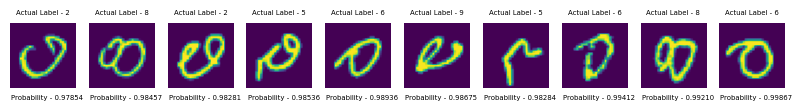

Predicted Label -  1
Wrong Predictions:


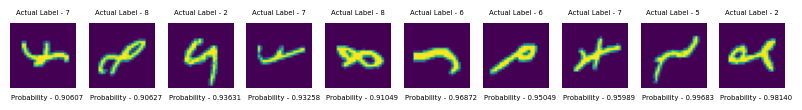

Predicted Label -  2
Wrong Predictions:


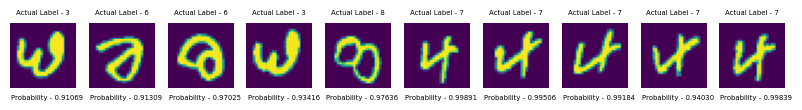

Predicted Label -  3
Wrong Predictions:


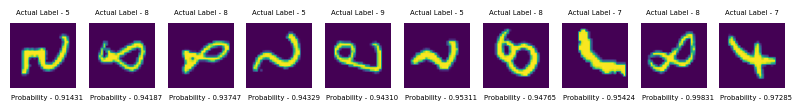

Predicted Label -  4
Wrong Predictions:


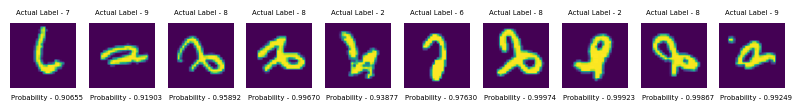

Predicted Label -  5
Wrong Predictions:


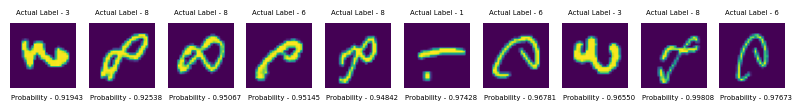

Predicted Label -  6
Wrong Predictions:


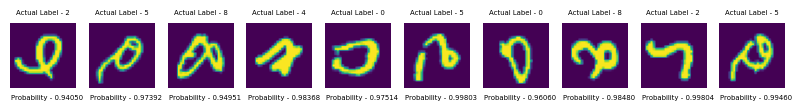

Predicted Label -  7
Wrong Predictions:


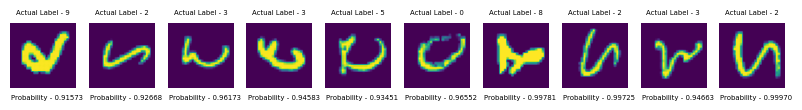

Predicted Label -  8
Wrong Predictions:


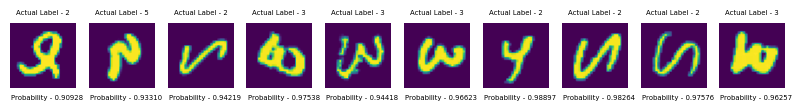

Predicted Label -  9
Wrong Predictions:


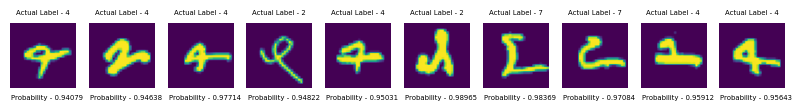

In [7]:
# Images with strongest wrong predicitons
def get_strongest_wrong_predictions(self, x_test, y_test, no_of_samples_per_class=10):
    op = np.array(x_test, dtype=np.float128)
    for layer in self.layers:
        op = layer.fwd_prop(op)
    idx_dic = {}
    for idx in range(10):
        idx_dic[idx] = []

    for idx in range(y_test.shape[0]):
        expected = y_test[idx].argmax()
        actual = op[idx].argmax()
        if actual != expected:
            if len(idx_dic[actual]) == no_of_samples_per_class:
                heapq.heapify(idx_dic[actual])
                if idx_dic[actual][0][0] < op[idx][actual]:
                    heapq.heappop(idx_dic[actual])
                    idx_dic[actual].append((op[idx][actual], expected, idx))
            else:
                idx_dic[actual].append((op[idx][actual], expected, idx))
    return idx_dic

Network.get_strongest_wrong_predictions = get_strongest_wrong_predictions
    
no_of_wrong_samples_per_class = 10
idx_dic = network.get_strongest_wrong_predictions(images_test, labels_test_one_hot, no_of_wrong_samples_per_class)
for idx in range(10):
    print('Predicted Label - ', idx)
    print('Wrong Predictions:')
    fig = plt.figure(figsize=(10, 10))
    for sample in range(no_of_wrong_samples_per_class):
        fig.add_subplot(1, no_of_wrong_samples_per_class, sample+1)
        plt.axis('off')
        plt.imshow(np.reshape(images_test[idx_dic[idx][sample][2]], (28, 28)))
        plt.text(0, 32, 'Probability - ' + '{:.5f}'.format(idx_dic[idx][sample][0]), fontdict={'fontsize': 5})
        plt.title('Actual Label - ' + str(idx_dic[idx][sample][1]), fontdict={'fontsize': 5})
    plt.show()

#### Exercise 3: Training with 1 example per class

[====================] 100% Epoch -  0 ; Loss -  6.562392014794704882
[====================] 100% Epoch -  1 ; Loss -  4.7551677949080407007
[====================] 100% Epoch -  2 ; Loss -  3.8163391601256141657
[====================] 100% Epoch -  3 ; Loss -  3.0586858154431761873
[====================] 100% Epoch -  4 ; Loss -  2.4452701482594011218
[====================] 100% Epoch -  5 ; Loss -  1.9402604906143583457
[====================] 100% Epoch -  6 ; Loss -  1.5159998850622865108
[====================] 100% Epoch -  7 ; Loss -  1.1712753269873632611
[====================] 100% Epoch -  8 ; Loss -  0.91041380663580260613
[====================] 100% Epoch -  9 ; Loss -  0.7160910713617491827
[====================] 100% Epoch -  10 ; Loss -  0.5655610235268039538
[====================] 100% Epoch -  11 ; Loss -  0.44827688696010638936
[====================] 100% Epoch -  12 ; Loss -  0.35932062369385720212
[====================] 100% Epoch -  13 ; Loss -  0.29363819726387535515

[====================] 100% Epoch -  112 ; Loss -  0.0142882532627516297745
[====================] 100% Epoch -  113 ; Loss -  0.014158500661375866249
[====================] 100% Epoch -  114 ; Loss -  0.014031157561864275829
[====================] 100% Epoch -  115 ; Loss -  0.013906156770252484347
[====================] 100% Epoch -  116 ; Loss -  0.013783433579812991375
[====================] 100% Epoch -  117 ; Loss -  0.013662925656737211483
[====================] 100% Epoch -  118 ; Loss -  0.013544572932074443839
[====================] 100% Epoch -  119 ; Loss -  0.013428317499531479412
[====================] 100% Epoch -  120 ; Loss -  0.013314103518764997768
[====================] 100% Epoch -  121 ; Loss -  0.0132018771238250886915
[====================] 100% Epoch -  122 ; Loss -  0.013091586336432330555
[====================] 100% Epoch -  123 ; Loss -  0.012983180983792996565
[====================] 100% Epoch -  124 ; Loss -  0.012876612620677515945
[====================] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


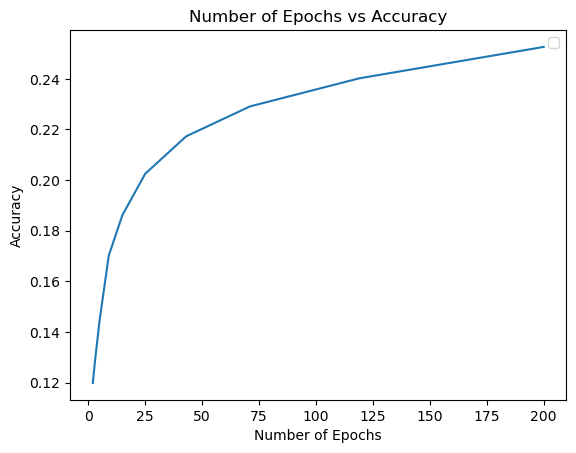

Final Accuracy -  0.25260000000000005


In [14]:
images_train_1_per_class = []
labels_train_1_per_class = []


for cls in range(10):
    idx = np.where(labels_train_1d == cls)
    images_train_1_per_class.append(images_train[idx[0][0]])
    labels_train_1_per_class.append(labels_train_one_hot[idx[0][0]])

# Training set with a single image per class
images_train_1_per_class = np.array(images_train_1_per_class)
labels_train_1_per_class = np.array(labels_train_1_per_class)
    
network_1_per_class = Network(0.1, 200, 10)
network_1_per_class.add_fc_layer(784, 10)
network_1_per_class.add_softmax_layer()

network_1_per_class.train_mbgd(images_train_1_per_class, labels_train_1_per_class, images_test, labels_test_one_hot)
plt.show()
print('Final Accuracy - ', network_1_per_class.test(images_test, labels_test_one_hot))

#### Exercise 4: Training with multiple batch sizes and comparison

Batch size -  1
Epoch -  0 ; Loss -  0.55218403924675403495
Epoch -  1 ; Loss -  0.35972232037225183274
Epoch -  2 ; Loss -  0.33076568446194227154
Epoch -  3 ; Loss -  0.31543082055652780918
Epoch -  4 ; Loss -  0.30545136456660890054
Epoch -  5 ; Loss -  0.29824711134649888077
Epoch -  6 ; Loss -  0.29271455750590016811
Epoch -  7 ; Loss -  0.28829150659698172602
Epoch -  8 ; Loss -  0.28465430717723017948
Epoch -  9 ; Loss -  0.28159936758543070647
Epoch -  10 ; Loss -  0.27899013200990456366
Epoch -  11 ; Loss -  0.27673065402297168083
Epoch -  12 ; Loss -  0.27475116339860662984
Epoch -  13 ; Loss -  0.27299955948303078316
Epoch -  14 ; Loss -  0.27143609189987492032
Epoch -  15 ; Loss -  0.2700298824438870364
Epoch -  16 ; Loss -  0.26875657040637435262
Epoch -  17 ; Loss -  0.2675966731662993297
Epoch -  18 ; Loss -  0.26653441844101186323
Epoch -  19 ; Loss -  0.2655568967062545621
Epoch -  20 ; Loss -  0.26465343602171667174
Epoch -  21 ; Loss -  0.26381513418489397016
Epoch -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch -  99 ; Loss -  0.24528698533345502722
Batch size -  10
Epoch -  0 ; Loss -  1.3023008816630135696
Epoch -  1 ; Loss -  0.59701311733508578134
Epoch -  2 ; Loss -  0.5027164657307976813
Epoch -  3 ; Loss -  0.45515981751421478443
Epoch -  4 ; Loss -  0.42499285037158033407
Epoch -  5 ; Loss -  0.40366021483115942323
Epoch -  6 ; Loss -  0.38756814753648699423
Epoch -  7 ; Loss -  0.37488826742575186943
Epoch -  8 ; Loss -  0.36457352986799351397
Epoch -  9 ; Loss -  0.3559744418590070891
Epoch -  10 ; Loss -  0.34866405084755855678
Epoch -  11 ; Loss -  0.34234909451170398038
Epoch -  12 ; Loss -  0.33682106879030075514
Epoch -  13 ; Loss -  0.3319274846938997966
Epoch -  14 ; Loss -  0.32755411858376004162
Epoch -  15 ; Loss -  0.3236136167461550767
Epoch -  16 ; Loss -  0.32003794612392108453
Epoch -  17 ; Loss -  0.31677325825302269974
Epoch -  18 ; Loss -  0.31377631257978534803
Epoch -  19 ; Loss -  0.3110119336163503348
Epoch -  20 ; Loss -  0.3084511695499858518
Epoch -  2

Epoch -  83 ; Loss -  0.36001378110233084353
Epoch -  84 ; Loss -  0.3590841966948310576
Epoch -  85 ; Loss -  0.35817142190063756225
Epoch -  86 ; Loss -  0.35727495232170441262
Epoch -  87 ; Loss -  0.35639430417203809146
Epoch -  88 ; Loss -  0.35552901322946855027
Epoch -  89 ; Loss -  0.35467863385070083526
Epoch -  90 ; Loss -  0.35384273804521917343
Epoch -  91 ; Loss -  0.35302091460397534183
Epoch -  92 ; Loss -  0.35221276827911920796
Epoch -  93 ; Loss -  0.35141791901132427099
Epoch -  94 ; Loss -  0.35063600120152862364
Epoch -  95 ; Loss -  0.34986666302415471105
Epoch -  96 ; Loss -  0.34910956577909277106
Epoch -  97 ; Loss -  0.3483643832799346803
Epoch -  98 ; Loss -  0.3476308012761288927
Epoch -  99 ; Loss -  0.3469085169068964034


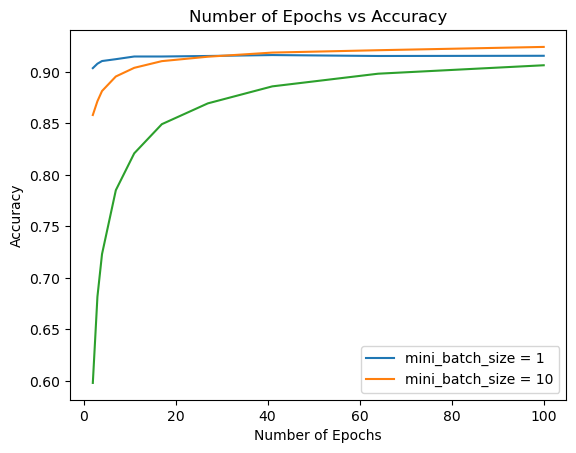

In [76]:
mini_batch_sizes = [1, 10, 100] # Multiple batch sizes
networks = [Network(0.01, 100, batch_size) for batch_size in mini_batch_sizes]
for network in networks:
    network.add_fc_layer(784, 10)
    network.add_softmax_layer()
    print('Batch size - ', network.batch_size)
    network.train_mbgd(images_train, labels_train_one_hot, images_test, labels_test_one_hot, False)
    
plt.show()

#### Exercise 5: Training with sorted data

Epoch -  0 ; Loss -  0.42065169505776041706
Epoch -  1 ; Loss -  0.2540072878440419328
Epoch -  2 ; Loss -  0.21138020820277856236
Epoch -  3 ; Loss -  0.19101470876558678048
Epoch -  4 ; Loss -  0.17828417799908762477
Epoch -  5 ; Loss -  0.16895358092044108678
Epoch -  6 ; Loss -  0.16172586031154221447
Epoch -  7 ; Loss -  0.15591380073851354893
Epoch -  8 ; Loss -  0.1510740497329523677
Epoch -  9 ; Loss -  0.14692617744836026357
Epoch -  10 ; Loss -  0.14329846672330221958
Epoch -  11 ; Loss -  0.14008126946647991237
Epoch -  12 ; Loss -  0.13719897253761305637
Epoch -  13 ; Loss -  0.13459624804546404778
Epoch -  14 ; Loss -  0.13223098433020856562
Epoch -  15 ; Loss -  0.1300701986912976994
Epoch -  16 ; Loss -  0.12808746761820913985
Epoch -  17 ; Loss -  0.12626120515199121887
Epoch -  18 ; Loss -  0.12457345971758054074
Epoch -  19 ; Loss -  0.123009057963519611574
Epoch -  20 ; Loss -  0.121554992520005827094
Epoch -  21 ; Loss -  0.120199983080863846445
Epoch -  22 ; Loss -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch -  99 ; Loss -  0.089866105732031096715


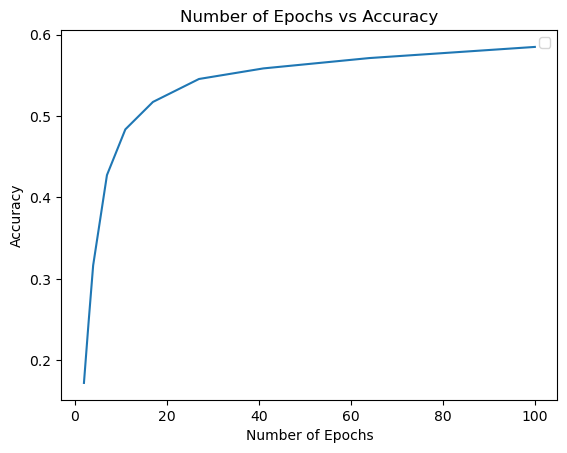

Final Accuracy -  0.585


In [16]:
sorted_train_indices = np.argsort(labels_train_1d)
images_train_sorted = images_train[sorted_train_indices]
labels_train_sorted_1d = labels_train_1d[sorted_train_indices]

# Sorted trainign set
labels_train_sorted_one_hot = np.zeros((labels_train_sorted_1d.size, 10))
labels_train_sorted_one_hot[np.arange(labels_train_sorted_1d.size), labels_train_sorted_1d] = 1

network = Network(0.01, 100, 10)
network.add_fc_layer(784, 10)
network.add_softmax_layer()
network.train_mbgd(images_train_sorted, labels_train_sorted_one_hot, images_test, labels_test_one_hot, False)
plt.show()
print('Final Accuracy - ', network.test(images_test, labels_test_one_hot))

#### Exercise 6: Network with two hidden layers, one with ReLU activation and the final layer with softmax activation and cross entropy loss

In [16]:
# Class for ReLU activation layer
class ReLULayer:
        input = None
        output = None
      
        def relu_activation(self):
            return np.maximum(self.input, 0)
        
        def gradient_relu_activation(self):
            return 1 * (self.input > 0)
        
        # Forward propagation
        def fwd_prop(self, inp):
            self.input = inp
            self.output = self.relu_activation()
            return self.output
        
        #Backward propagation
        def back_prop(self, error, learning_rate):
            return self.gradient_relu_activation() * error
        
# Add a ReLU layer to the network
def add_relu_layer(self):
    ac_layer = ReLULayer()
    self.layers.append(ac_layer)

Network.add_relu_layer = add_relu_layer

[====================] 100% Epoch -  0 ; Loss -  1.1827004490108842104
[====================] 100% Epoch -  1 ; Loss -  0.603399616551882854
[====================] 100% Epoch -  2 ; Loss -  0.50560379174541638373
[====================] 100% Epoch -  3 ; Loss -  0.45495461772742336196
[====================] 100% Epoch -  4 ; Loss -  0.42082969059609544584
[====================] 100% Epoch -  5 ; Loss -  0.3950934825807884478
[====================] 100% Epoch -  6 ; Loss -  0.37610671764242218143
[====================] 100% Epoch -  7 ; Loss -  0.3614386762851748284
[====================] 100% Epoch -  8 ; Loss -  0.34928157781478120288
[====================] 100% Epoch -  9 ; Loss -  0.3392096214885558994
[====================] 100% Epoch -  10 ; Loss -  0.3305953605224234926
[====================] 100% Epoch -  11 ; Loss -  0.32300305087316186778
[====================] 100% Epoch -  12 ; Loss -  0.3162146407737820591
[====================] 100% Epoch -  13 ; Loss -  0.31015162170347338

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


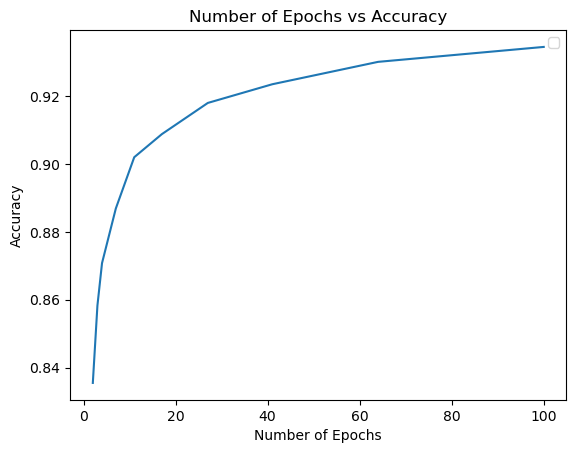

Final Accuracy -  0.9345


In [22]:
# Initialize network with ReLU layer
network_with_relu = Network(0.01, 100, 10)
network_with_relu.add_fc_layer(784, 11)
network_with_relu.add_relu_layer()
network_with_relu.add_fc_layer(11, 10)
network_with_relu.add_softmax_layer()
network_with_relu.train_mbgd(images_train, labels_train_one_hot, images_test, labels_test_one_hot)
plt.show()
print('Final Accuracy - ', network_with_relu.test(images_test, labels_test_one_hot))